In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import math
import akshare as ak
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential

In [2]:
class ETFpool():    
    def __init__(self, tickers) -> None:
        """
        初始化函数

        Args:
        tickers: ETF池的代码列表

        Returns:
        None
        """
        super().__init__()
        self.tickers = tickers
        self.data = None

    def get_data(self, start_date: str = "19700101",end_date: str = "20500101") -> None:
        """
        利用akshare获取ETF池的各支ETF的历史数据，重命名列名，合并各支ETF的价格以及均线数据到data属性

        Args:
        start_date: 开始日期
        end_date: 结束日期

        Returns:
        None
        """

        etf_data = {}
        etf_symbols = self.tickers
        window = 21

        # 获取 ETF 历史数据
        # 关于akshare接口的说明：https://akshare.akfamily.xyz/data/fund/fund_public.html#id7
        for symbol in etf_symbols:
            etf_df = ak.fund_etf_hist_em(symbol=symbol, period="daily", start_date= start_date, end_date= end_date, adjust='hfq')[['日期', '收盘', '成交量']] \
                .rename(columns={'日期': 'date', '收盘': symbol, '成交量': f'{symbol}_volume'}).set_index('date')
            etf_data[symbol] = etf_df

        # 合并数据并对齐
        data = pd.concat(list(etf_data.values()), axis=1).dropna()
        data.index = pd.to_datetime(data.index)

        # 计算每日涨跌幅和滚动收益率
        for symbol in etf_symbols:
            column_name = f"{symbol}"
            data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x: x[-1] / x[0] - 1)
            data[f"{column_name}_return"] = data[column_name].rolling(window=window).apply(lambda x: x[-1] / x[0] - 1)
            data[f"{column_name}_ma"] = data[column_name].rolling(window=window).mean()

        # 去掉缺失值
        data = data.dropna()

        # 依照动量策略选取信号
        data['signal'] = data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1).str.split('_').str[0]
        data['signal'] = data['signal'].shift(1)
        data = data.dropna()
        data['signal_day_return'] = data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1)
        data["signal_return"] = (np.cumprod(data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1) + 1) * 100)
        data = data.dropna()

        # 保存基准策略收益率
        data['base_strategy_day_return'] = data["signal_day_return"].apply(deepcopy)
        data['base_strategy_return'] = data["signal_return"].apply(deepcopy)

        self.data = data

    def rnn_predict(self):
        """
        利用RNN模型对ETF池的各支ETF进行预测

        Args:
        None

        Returns:
        None
        """
        etf_symbols = self.tickers

        # 获取数据并保存csv到当前目录
        for symbol in etf_symbols:
            df = deepcopy(self.data)
            df = df[[symbol,f'{symbol}_volume']]
            df = df.rename(columns={symbol: 'Close', f'{symbol}_volume':'Volume'})
            df = df.dropna()
            df.to_csv(f'{symbol}_data.csv')

            def rnn_predict(ticker):
                # 读取数据
                df = pd.read_csv(f"./{ticker}_data.csv", index_col=0)

                # 存储前一天的数据
                df["previous_close"] = df['Close'].shift(1)
                df = df.dropna() # 删除缺失值

                # 数据归一化
                df2 = df.apply(deepcopy)
                df2['DateIndex'] = pd.to_datetime(df2.index, format="%Y-%m-%d")
                df2 = df2.set_index('DateIndex')
                cols = ['Close', 'Volume', 'previous_close']
                features = df2[cols]
                scaler = MinMaxScaler(feature_range=(0, 1)).fit(features.values)
                features = scaler.transform(features.values)
                df2[cols] = features

                # 收盘价设为目标字段
                X = df2.drop(['Close'], axis =1)
                y = df2['Close']

                # 计算切分点（以80%的训练数据为例）
                train_percentage = 0.8
                split_point = math.floor(len(X) * train_percentage)
                

                # 时序切分
                train_x, train_y = X[:split_point], y[:split_point]
                test_x, test_y = X[split_point:], y[split_point:]

                # 构建滑窗数据
                def genWindows(X_in, y_in, window_size):
                    X_out = []
                    y_out = []
                    length = X_in.shape[0]
                    for i in range(window_size, length):
                        X_out.append(X_in[i-window_size:i, 0:4])
                        y_out.append(y_in[i-1])
                    return np.array(X_out), np.array(y_out)

                # 窗口大小为5
                window_size = 5
                X_train_win, y_train_win = genWindows(np.array(train_x), np.array(train_y), window_size)
                X_test_win, y_test_win = genWindows(np.array(test_x), np.array(test_y), window_size)
                from tensorflow.keras import callbacks

                # 早停止 回调函数
                callback_early_stopping = callbacks.EarlyStopping(
                    monitor="loss",
                    patience=10,#look at last 10 epochs
                    min_delta=0.0001,#loss must improve by this amount
                    restore_best_weights=True,
                )

                # 构建RNN模型，结构为 输入-RNN-RNN-连续值输出
                input_shape=(X_train_win.shape[1],X_train_win.shape[2])
                print(input_shape)
                model = Sequential(
                    [
                        layers.Input(shape=input_shape),
                        layers.SimpleRNN(units=128, return_sequences=True),
                        layers.SimpleRNN(64, return_sequences=False),
                        layers.Dense(1, activation="linear"),
                    ]
                )

                # 优化器
                optimizer = keras.optimizers.Nadam(learning_rate=0.0001)
                model.compile(optimizer=optimizer, loss="mse")

                # 模型结构总结
                model.summary()

                # 模型训练
                batch_size = 20
                epochs = 50
                history = model.fit(X_train_win, y_train_win,
                batch_size=batch_size, epochs=epochs,
                callbacks=[
                    callback_early_stopping
                    ])
                # 训练集预测
                pred_train_y = model.predict(X_train_win)

                # 绘图
                plt.figure(figsize=(15, 6), dpi=80)
                plt.plot(np.array(train_y))
                plt.plot(pred_train_y)
                plt.legend(['Actual', 'Predictions'])
                plt.title(f'{ticker} Traning Set Predictions')
                #plt.show()

                # 测试集预测
                pred_test_y = model.predict(X_test_win)
                
                # 预测结果绘制
                plt.figure(figsize=(15, 6), dpi=80)
                plt.plot(np.array(test_y))
                plt.plot(pred_test_y)
                plt.legend(['Actual', 'Predictions'])
                plt.title(f'{ticker} Test Set Predictions')
                #plt.show()

            # 对每支ETF进行预测
            for symbol in etf_symbols:
                rnn_predict(symbol)



In [3]:
pool_1 = ETFpool(['159915'])
pool_1.get_data(start_date='2020101', end_date='20240101')


(5, 2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 5, 128)         │        16,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,185 (114.00 KB)

 Trainable params: 29,185 (114.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0076
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8890e-04
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7006e-04
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5518e-04
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1705e-04
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0088e-04
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9217e-04
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5993e-04
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0970e-04
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6332e-04
Epoch 12/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8821e-04
Epoch 13/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5852e-04
Epoch 14/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9264e-04
Epoch 15/

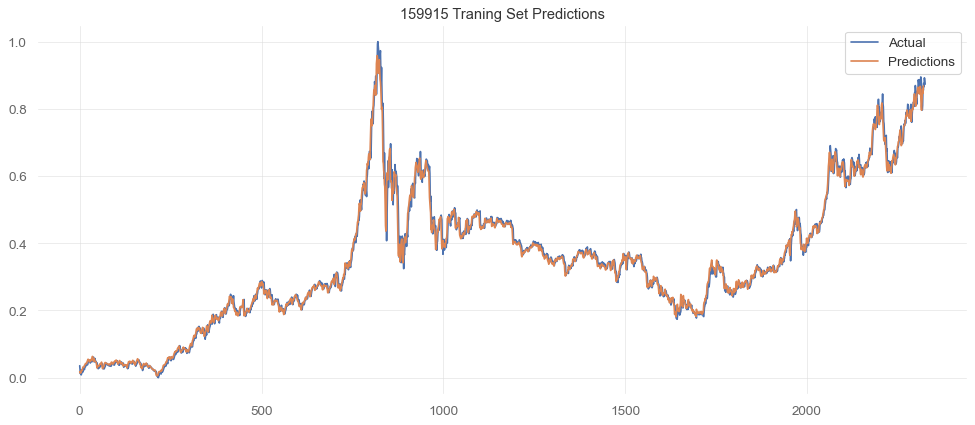

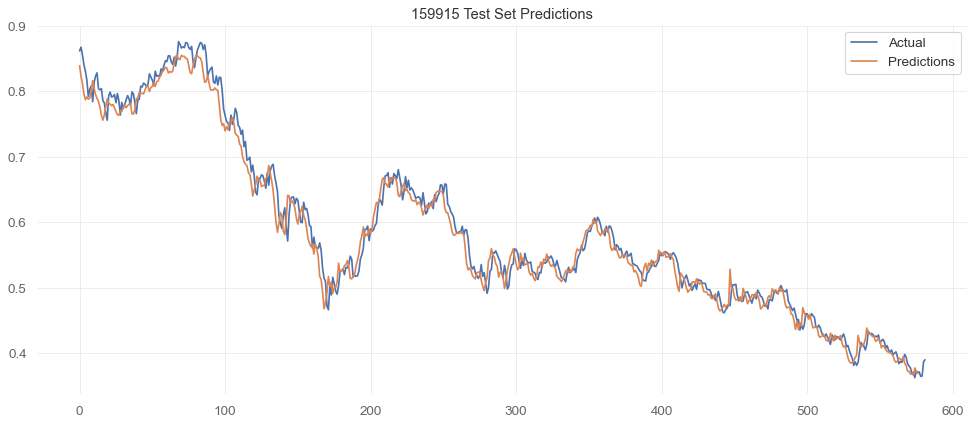

In [4]:
pool_1.rnn_predict()